## Google Colab Integration

In [ ]:
!rm -rf *
!git clone https://github.com/Stage-SuperResolution/MumfordShah.git
!mv MumfordShah/* .
!rm -rf MumfordShah
# !pip uninstall lasp -y
!pip install git+https://github.com/akhaten/lasp.git@6424edd52f131a946da3fc088013ed893bc65df5

## Configure Path

In [23]:
import pathlib

DATASET_PATH = pathlib.Path('dataset.pkl')
# if DATASET_PATH.exists() :
#     raise AssertionError('{} exists. To make a new dataset, change name or delete it'.format(DATASET_PATH))

## Create dataset

In [24]:
import pathlib
import pandas
import numpy

def add(
    dataset: pandas.DataFrame,
    image: pathlib.Path,
    alpha: float,
    beta: float,
    sigma: float,
    deblur_kernel: tuple[int, float],
    tol: float = 10**(-4),
    iterations: int = 300,
    blur: tuple[int, float] = numpy.nan,
    noise: float = numpy.nan
) -> pandas.DataFrame:

    to_add = pandas.DataFrame(
        {
            'image' : [image], 
            'alpha' : [alpha], 
            'beta' : [beta], 
            'sigma' : [sigma],
            'deblur kernel' : [deblur_kernel], 
            'tol' : [tol], 
            'iterations' : [iterations], 
            'blur' : [blur], 
            'noise' : [noise]
        }
    )

    return pandas.concat([dataset, to_add], ignore_index=True)

In [25]:
dataset = pandas.DataFrame(columns=['image' , 'alpha', 'beta', 'sigma', 'deblur kernel', 'tol', 'iterations', 'blur', 'noise'])

dataset = add(dataset, pathlib.Path('./inputs/Baboon.bmp'), 100, 1, 2, (3, 3), 10**(-4), 300, (3, 3), numpy.nan)
dataset = add(dataset, pathlib.Path('./inputs/Baboon.bmp'), 100, 1, 2, (7, 3), 10**(-4), 300, (7, 3), numpy.nan)
dataset = add(dataset, pathlib.Path('./inputs/Baboon.bmp'), 100, 1, 2, (15, 3), 10**(-4), 300, (15, 3), numpy.nan)

dataset = add(dataset, pathlib.Path('./inputs/Baboon.bmp'), 100, 1, 2, (3, 3), 10**(-4), 300, numpy.nan, 30)
dataset = add(dataset, pathlib.Path('./inputs/Baboon.bmp'), 100, 1, 2, (7, 3), 10**(-4), 300, numpy.nan, 20)
dataset = add(dataset, pathlib.Path('./inputs/Baboon.bmp'), 100, 1, 2, (15, 3), 10**(-4), 300, numpy.nan, 10)

# dataset = add(dataset, pathlib.Path('./inputs/Baboon.bmp'), 100, 1, 2, (3, 3), 10**(-4), 300, numpy.nan, 1)
# dataset = add(dataset, pathlib.Path('./inputs/Baboon.bmp'), 100, 1, 2, (7, 3), 10**(-4), 300, numpy.nan, 1)
# dataset = add(dataset, pathlib.Path('./inputs/Baboon.bmp'), 100, 1, 2, (15, 3), 10**(-4), 300, numpy.nan, 1)

dataset = add(dataset, pathlib.Path('./inputs/Baboon.bmp'), 100, 1, 2, (3, 3), 10**(-4), 300, (3, 3), 30)
dataset = add(dataset, pathlib.Path('./inputs/Baboon.bmp'), 100, 1, 2, (7, 3), 10**(-4), 300, (3, 3), 20)
dataset = add(dataset, pathlib.Path('./inputs/Baboon.bmp'), 100, 1, 2, (15, 3), 10**(-4), 300, (3, 3), 10)

dataset = add(dataset, pathlib.Path('./inputs/Baboon.bmp'), 100, 1, 2, (3, 3),  10**(-4), 300, (7, 3), 30)
dataset = add(dataset, pathlib.Path('./inputs/Baboon.bmp'), 100, 1, 2, (7, 3),  10**(-4), 300, (7, 3), 20)
dataset = add(dataset, pathlib.Path('./inputs/Baboon.bmp'), 100, 1, 2, (15, 3), 10**(-4), 300, (7, 3), 10)

dataset = add(dataset, pathlib.Path('./inputs/Baboon.bmp'), 100, 1, 2, (3, 3), 10**(-4), 300, (15, 3), 30)
dataset = add(dataset, pathlib.Path('./inputs/Baboon.bmp'), 100, 1, 2, (7, 3), 10**(-4), 300, (15, 3), 20)
dataset = add(dataset, pathlib.Path('./inputs/Baboon.bmp'), 100, 1, 2, (15, 3), 10**(-4), 300, (15, 3), 10)

In [26]:
pandas.to_pickle(dataset, DATASET_PATH)
# dataset[numpy.logical_and(dataset['noise'] == 30, dataset['blur'] == (3, 3))]
# dataset[]
# (dataset['noise'] == 30) and (dataset['blur'] == (3, 3))


## Process Dataset

In [27]:
import sys
sys.path.append('../../..')

import lasp.io
import lasp.filters.linear
import lasp.noise

import scipy.signal

def image_from(params: pandas.Series) -> numpy.ndarray:

    image_path = params['image']
    blur = params['blur']
    noise = params['noise']

    img = lasp.io.read(image_path)
    out = numpy.copy(img)

    if pandas.notna(blur):
        kernel = lasp.filters.linear.gaussian_filter(size=blur[0], sigma=blur[1])
        out = scipy.signal.convolve2d(out, kernel, mode='same')
    
    if pandas.notna(noise):
        out = lasp.noise.awgn(out, snr=noise)

    return out

def images_from(params: pandas.Series) -> tuple[numpy.ndarray, numpy.ndarray]:

    image_path = params['image']
    blur = params['blur']
    noise = params['noise']


    img = lasp.io.read(image_path)
    out = numpy.copy(img)

    if pandas.notna(blur):
        kernel = lasp.filters.linear.gaussian_filter(size=blur[0], sigma=blur[1])
        out = scipy.signal.convolve2d(out, kernel, mode='same')
    
    if pandas.notna(noise):
        out = lasp.noise.awgn(out, snr=noise)

    return img, out

In [28]:
import numpy
import lasp.differential
import lasp.utils
import lasp.filters.linear
import lasp.thresholding

def mumford_shah(
    y: numpy.ndarray, 
    h: numpy.ndarray, 
    alpha: float,
    beta: float,
    sigma: float,
    nb_iterations: int,
    tolerance: float,
    error_history: list[float] = None
) -> numpy.ndarray:

    """Mumford Shah
    
    Solve argmin_{x} { (alpha/2) || y - Hx ||^2 + (beta/2) || nabla y ||^2 + || nabla y ||_1
    """

    Dx = lasp.differential.dx
    Dy = lasp.differential.dy
    Dxt = lasp.differential.dxT
    Dyt = lasp.differential.dyT

    # Build kernel
    uker = numpy.zeros_like(y)

    laplacian = lasp.filters.linear.laplacian()
    lap_diag = lasp.utils.fourier_diagonalization(
        kernel = laplacian,
        shape_out = y.shape 
    )
   
    h_diag = lasp.utils.fourier_diagonalization(
        kernel = h,
        shape_out = y.shape
    )

    h2_diag = numpy.abs(h_diag)**2


    uker = alpha * h2_diag + (beta+sigma) * lap_diag

    rhs1fft = alpha * numpy.conj(h_diag) * numpy.fft.fft2(y)

    # Initialization
    u = numpy.copy(y) 
    d_x=numpy.zeros_like(y)
    d_y=numpy.zeros_like(y)
    b_x=numpy.zeros_like(y)
    b_y=numpy.zeros_like(y)

    for _ in range(0, nb_iterations):

        rhs2 = sigma*Dxt(d_x-b_x)+sigma*Dyt(d_y-b_y)
        rhsfft = rhs1fft + numpy.fft.fft2(rhs2)

        u0=numpy.copy(u)
        
        u = numpy.real(numpy.fft.ifft2(rhsfft / uker))    

        err = numpy.linalg.norm(u-u0, 'fro') / numpy.linalg.norm(u, 'fro')
        
        if not(error_history is None):
            error_history.append(err)

        if err < tolerance:
            break
        
        d_x, d_y = lasp.thresholding.multidimensional_soft(
            d = numpy.array([ Dx(u)+b_x, Dy(u)+b_y ]),
            epsilon = 1/sigma
        )

        b_x=b_x+Dx(u)-d_x
        b_y=b_y+Dy(u)-d_y

    u_normalized = lasp.utils.normalize(u)

    return u_normalized

In [29]:
import lasp.utils
import lasp.filters.linear
import lasp.io

dataset = pandas.read_pickle(DATASET_PATH)

RESULTS_PATH = pathlib.Path('./results')
if not(RESULTS_PATH.exists()):
    RESULTS_PATH.mkdir() 

for i in dataset.index:

    RES_CURRENT_PATH = RESULTS_PATH / str(i)
    if not(RES_CURRENT_PATH.exists()):
        RES_CURRENT_PATH.mkdir()

    params = dataset.iloc[i]

    out = image_from(params)
    normalized = lasp.utils.normalize(out)

    alpha = params['alpha']
    beta = params['beta']
    sigma = params['sigma']
    tol = params['tol']
    iterations = params['iterations']
    deblur_kernel = lasp.filters.linear.gaussian_filter(
        size = dataset.iloc[i]['deblur kernel'][0],
        sigma = dataset.iloc[i]['deblur kernel'][1]
    )

    errors = []

    res = mumford_shah(normalized, deblur_kernel, alpha, beta, sigma, iterations, tol, errors)

    lasp.io.save(res, RES_CURRENT_PATH / 'result.npy')
    lasp.io.save(res, RES_CURRENT_PATH / 'result.png')
    lasp.io.save(errors, RES_CURRENT_PATH / 'errors.npy')

In [30]:
def process_from_index(dataset: pandas.DataFrame, index: int) -> tuple[numpy.ndarray, numpy.ndarray]:
   
    params = dataset.iloc[i]

    out = image_from(params)
    normalized = lasp.utils.normalize(out)

    alpha = params['alpha']
    beta = params['beta']
    sigma = params['sigma']
    tol = params['tol']
    iterations = params['iterations']
    deblur_kernel = lasp.filters.linear.gaussian_filter(
        size = dataset.iloc[i]['deblur kernel'][0],
        sigma = dataset.iloc[i]['deblur kernel'][1]
    )

    errors = []

    res = mumford_shah(normalized, deblur_kernel, alpha, beta, sigma, iterations, tol, errors)

    return res, errors

## Plots

In [31]:
import pandas
import matplotlib.pyplot
import lasp.io

def title_from(params: pandas.Series) -> str:

    alpha = params['alpha']
    beta = params['beta']
    sigma = params['sigma']
    tol = params['tol']
    iterations = params['iterations']
    blur = params['blur']
    deblur = params['deblur kernel']
    noise = params['noise']

    params_algo_str = 'Params : ($\\alpha$={}, $\\beta$={}, $\sigma$={}, tol={}, nb_iters={})\n'.format(
        alpha, beta, sigma, tol, iterations
    )

    params_blur_str = ''
    if not(pandas.isna(blur)):
        params_blur_str = 'Blur filter : {}x{}, $\sigma$={}\n'.format(blur[0], blur[0], blur[1])

    params_noise_str = ''
    if not(pandas.isna(noise)):
        params_noise_str = 'Noise : {} (not dB)\n'.format(noise)
    
    params_deblur_str = 'Deblur filter : {}x{}, $\sigma$={}\n'.format(deblur[0], deblur[0], deblur[1])

    title = params_algo_str+params_blur_str+params_noise_str+params_deblur_str
    
    return title

import matplotlib
matplotlib.rcParams['figure.facecolor'] = '303030'
matplotlib.rcParams['axes.facecolor'] = '303030'
matplotlib.rcParams['text.color'] = 'FFFFFF'
matplotlib.rcParams['xtick.color'] = 'FFFFFF'
matplotlib.rcParams['ytick.color'] = 'FFFFFF'
matplotlib.rcParams['axes.labelcolor'] = 'FFFFFF'

def plot2x2(dataset: pandas.DataFrame, index: int) -> None:
    
    
    params = dataset.iloc[index]
    

    original, y = images_from(params)
    y = image_from(params)

    RES_PATH = RESULTS_PATH / str(i)
    res = lasp.io.read(RES_PATH / 'result.npy')
    errors = lasp.io.read(RES_PATH / 'errors.npy')

    figure = matplotlib.pyplot.figure(
        figsize=(10, 10)
    )
    
    figure.subplots_adjust(top=0.85)
    
    title = title_from(params)
    figure.suptitle('Mumford-Shah \n'+title)
    # figure.tight_layout()
    
    # plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

    ax = figure.subplots(2, 2)

    ax[0, 0].axis('off')
    ax[0, 0].set_title('Original')
    ax[0, 0].imshow(original, cmap='gray')

    ax[0, 1].axis('on')
    ax[0, 1].grid('on')
    ax[0, 1].set_xlabel('Iterations')
    ax[0, 1].set_ylabel('Errors')
    ax[0, 1].plot(errors)

    ax[1, 0].axis('off')
    ax[1, 0].set_title('Img')
    ax[1, 0].imshow(y, cmap='gray')

    ax[1, 1].axis('off')
    ax[1, 1].set_title('Result')
    ax[1, 1].imshow(res, cmap='gray')

    figure.savefig(RES_PATH / ('figure2x2.png'))

In [32]:
# dataset_filtered = dataset[numpy.logical_and(~pandas.isna(dataset['noise']), pandas.isna(dataset['blur']))]
# dataset_filtered

dataset_filtered = dataset
dataset_filtered

image alpha beta sigma deblur kernel     tol iterations  \
0   inputs/Baboon.bmp   100    1     2        (3, 3)  0.0001        300   
1   inputs/Baboon.bmp   100    1     2        (7, 3)  0.0001        300   
2   inputs/Baboon.bmp   100    1     2       (15, 3)  0.0001        300   
3   inputs/Baboon.bmp   100    1     2        (3, 3)  0.0001        300   
4   inputs/Baboon.bmp   100    1     2        (7, 3)  0.0001        300   
5   inputs/Baboon.bmp   100    1     2       (15, 3)  0.0001        300   
6   inputs/Baboon.bmp   100    1     2        (3, 3)  0.0001        300   
7   inputs/Baboon.bmp   100    1     2        (7, 3)  0.0001        300   
8   inputs/Baboon.bmp   100    1     2       (15, 3)  0.0001        300   
9   inputs/Baboon.bmp   100    1     2        (3, 3)  0.0001        300   
10  inputs/Baboon.bmp   100    1     2        (7, 3)  0.0001        300   
11  inputs/Baboon.bmp   100    1     2       (15, 3)  0.0001        300   
12  inputs/Baboon.bmp   100    1     2        (3, 3)  0.0001        300   
13  inputs/Baboon.bmp   100    1     2        (7, 3)  0.0001        300   
14  inputs/Baboon.bmp   100    1     2       (15, 3)  0.0001        300   

       blur noise  
0    (3, 3)   NaN  
1    (7, 3)   NaN  
2   (15, 3)   NaN  
3       NaN    30  
4       NaN    20  
5       NaN    10  
6    (3, 3)    30  
7    (3, 3)    20  
8    (3, 3)    10  
9    (7, 3)    30  
10   (7, 3)    20  
11   (7, 3)    10  
12  (15, 3)    30  
13  (15, 3)    20  
14  (15, 3)    10

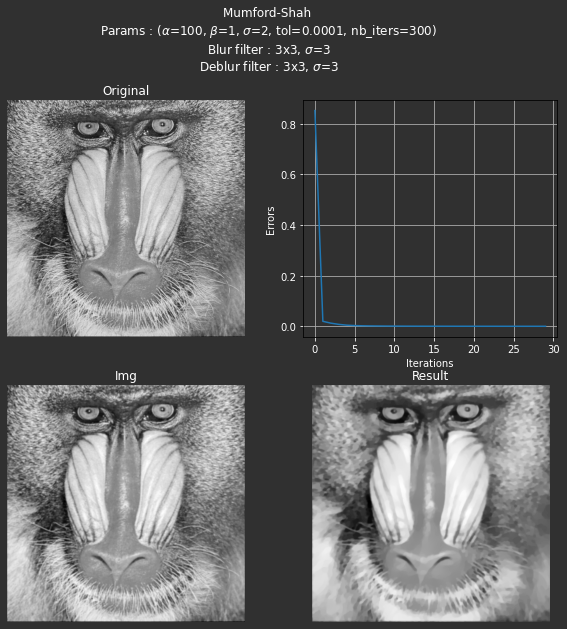

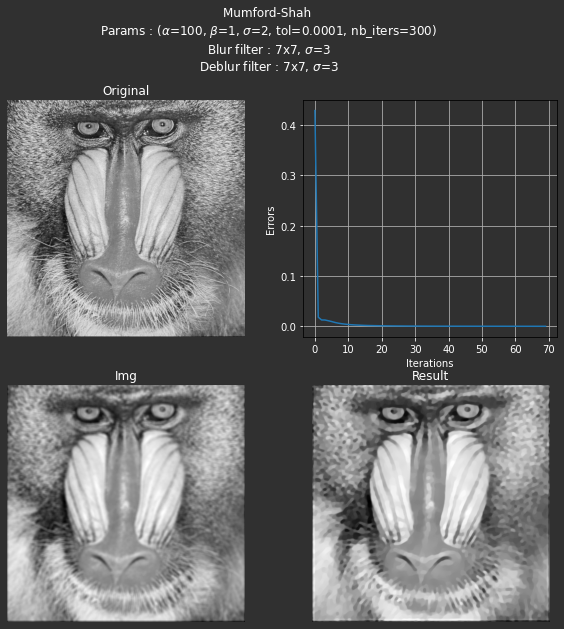

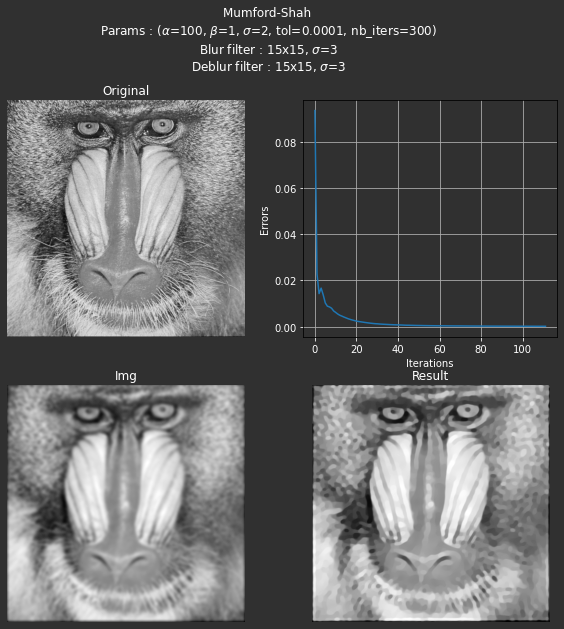

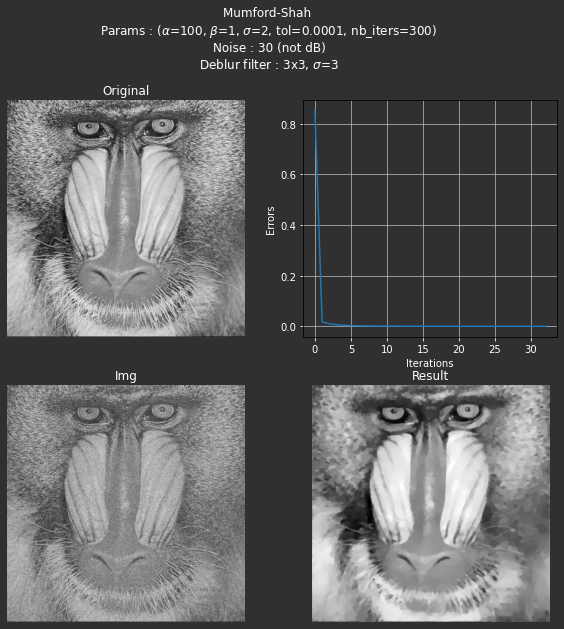

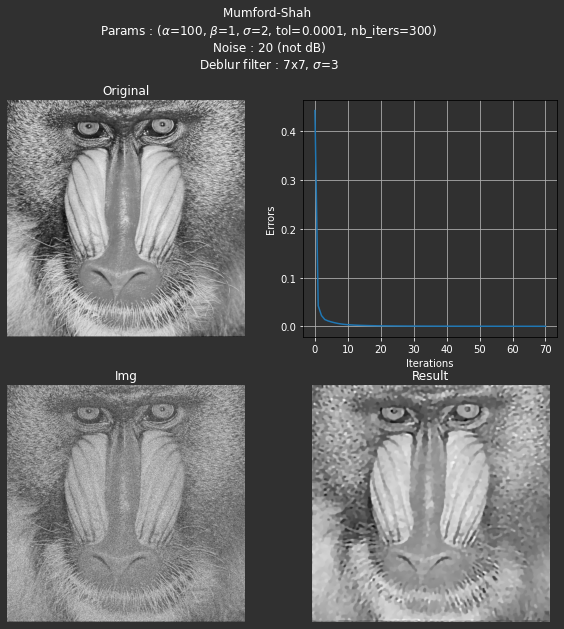

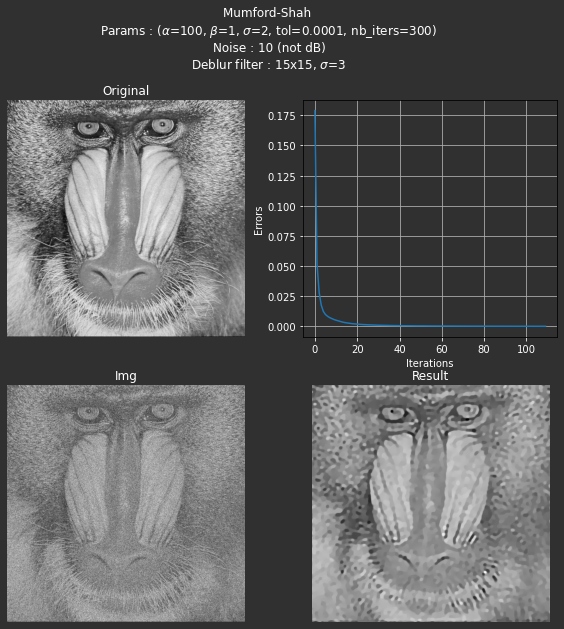

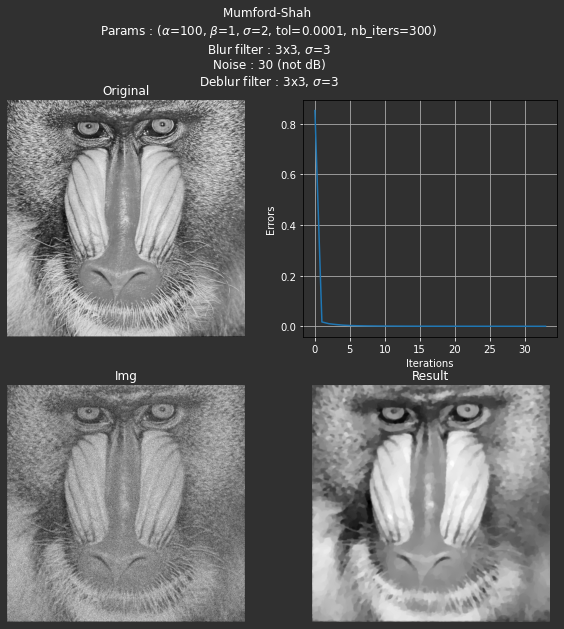

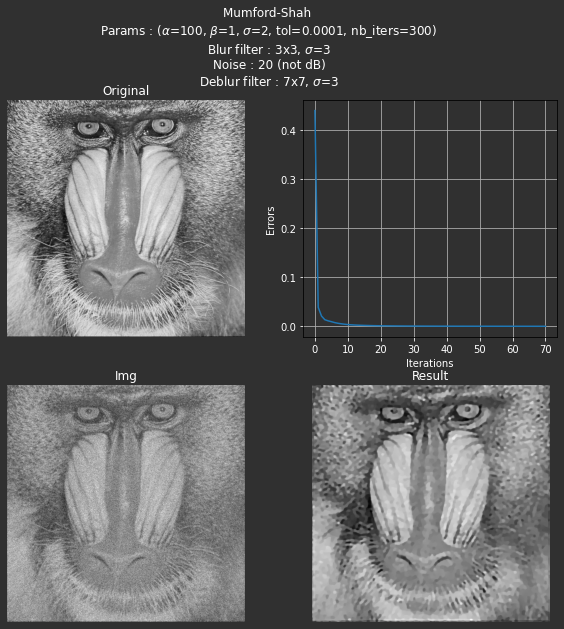

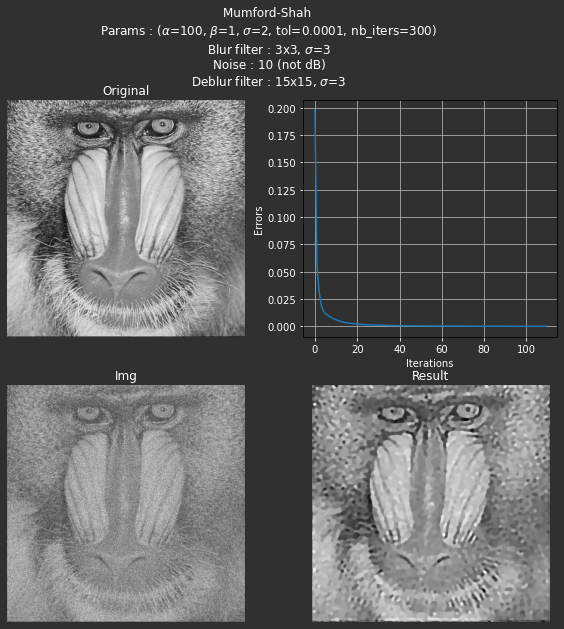

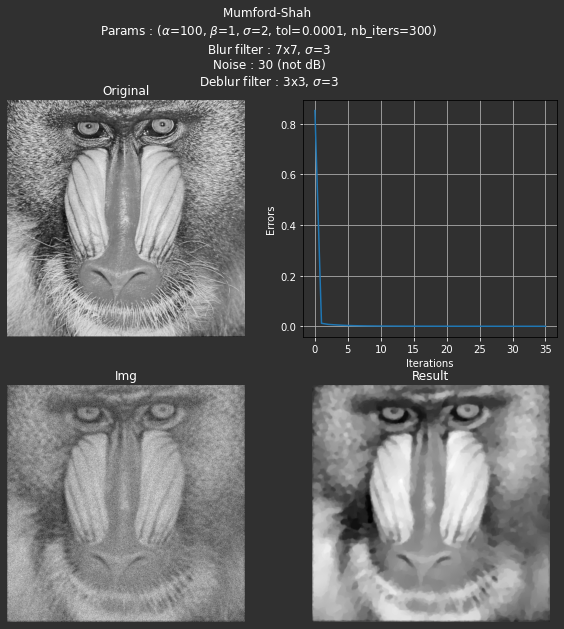

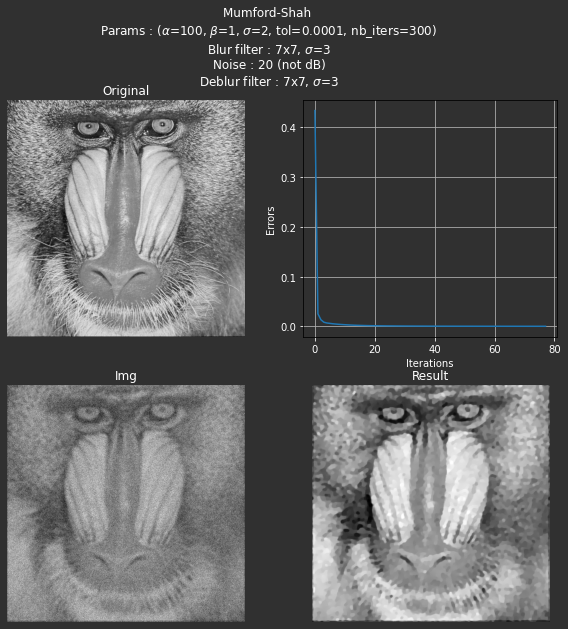

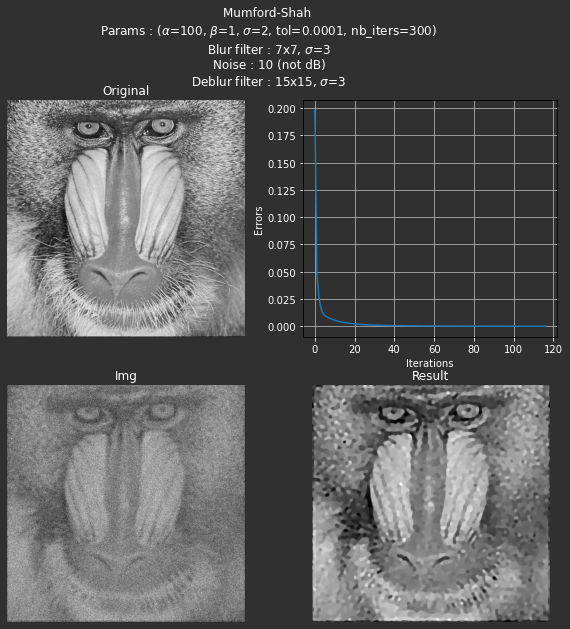

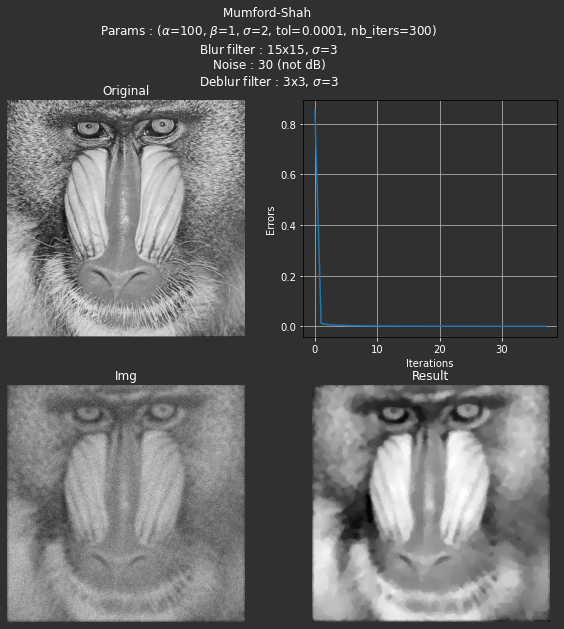

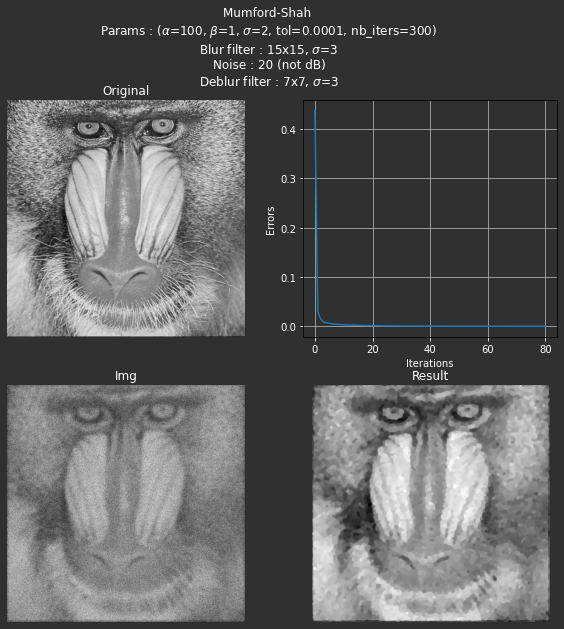

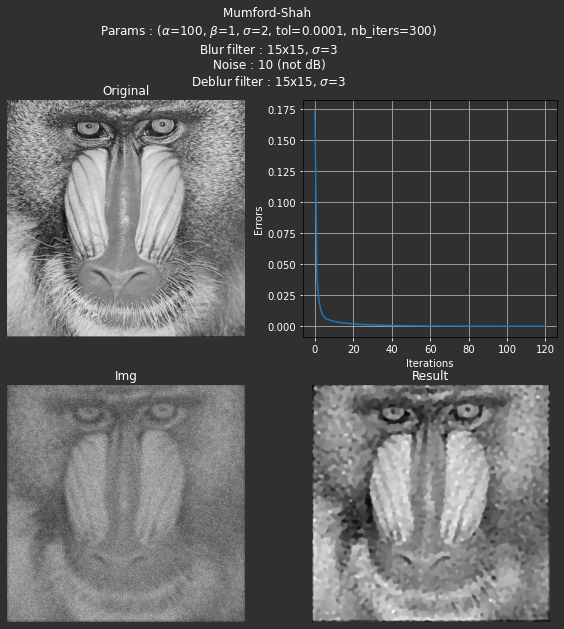

In [33]:
for i in dataset_filtered.index:
    plot2x2(dataset, i)